# Notebook 3: School 'flu epidemic estimation  
### Peter.Nolan@gmail.com
### https://github.com/dpnolan/pandemic

Model here uses the data and setup from: 

Léo Grinsztaj,  Elizaveta Semenov,  Charles C Margossia3, Julien Rio
"Bayesian workflow for disease transmission modeling in Stan"
4
https://pmc.ncbi.nlm.nih.gov/articles/PMC8661657/pdf/SIM-40-6209.pdf

Code:\
https://github.com/charlesm93/disease_transmission_workflow/blob/main/README.md

Used as an example in the STAN documentation:\
https://mc-stan.org/learn-stan/case-studies/boarding_school_case_study.html

## Data sources 
Estimation uses dataset from a 14 days influenza outbreak in a British boarding school with 763 male students\
Communicable Diseases Surveillance Centre, Influenza in a boarding school. BMJ, 4 March 1978, 1, p.587.\
\
Dataset\
https://www.kaggle.com/datasets/antonymgitau/influenza-england-1978-school-csv

Article\
http://alun.math.ncsu.edu/wp-content/uploads/sites/2/2017/01/influenza_78.pdf

In [ ]:
#!conda list --export > requirements.txt

## Setup

uses kernel pymc_env_1 on PC

#!conda list --export > requirements.txt

In [3]:
import numpy as np
import pymc as pm
import pytensor.tensor as pt
import pandas as pd
import arviz as az
from pytensor import scan
import matplotlib.pyplot as plt
import csv
from datetime import datetime

## Data Entry

In [4]:
df = pd.read_csv("influenza_england_1978_school.csv",index_col=0)

In [5]:
df

,date,in_bed,convalescent
1,1978-01-22,3,0
2,1978-01-23,8,0
3,1978-01-24,26,0
4,1978-01-25,76,0
5,1978-01-26,225,9
6,1978-01-27,298,17
7,1978-01-28,258,105
8,1978-01-29,233,162
9,1978-01-30,189,176
10,1978-01-31,128,166


In [6]:
df.in_bed=df.in_bed*1.0 #school example
df=df.rename(columns={"in_bed": "I","convalescent":"R"})
df

,date,I,R
1,1978-01-22,3.0,0
2,1978-01-23,8.0,0
3,1978-01-24,26.0,0
4,1978-01-25,76.0,0
5,1978-01-26,225.0,9
6,1978-01-27,298.0,17
7,1978-01-28,258.0,105
8,1978-01-29,233.0,162
9,1978-01-30,189.0,176
10,1978-01-31,128.0,166


In [7]:
infected = df['I'].reset_index(drop=True)
infected

0       3.0
1       8.0
2      26.0
3      76.0
4     225.0
5     298.0
6     258.0
7     233.0
8     189.0
9     128.0
10     68.0
11     29.0
12     14.0
13      4.0
Name: I, dtype: float64

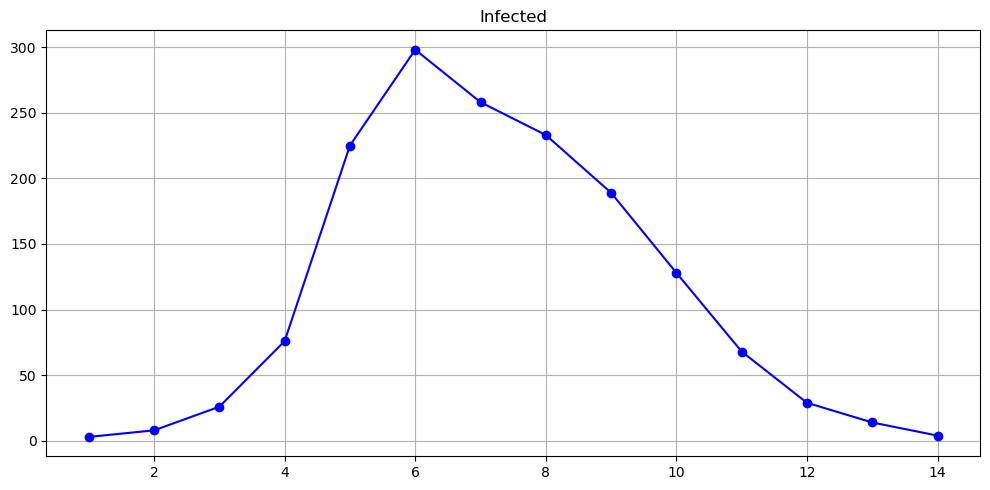

<Figure size 640x480 with 0 Axes>

In [8]:
df['I'].plot(figsize=(10, 5), title='Infected',color='blue',marker='o')
plt.grid(True)
plt.tight_layout()
plt.show()
plt.savefig('school1.png')

In [12]:
sum(df['I']<0)

0

## Model Setup

In [13]:
N = 763 #total number of students

In [14]:
n_days = len(infected)
times = np.arange(n_days)
t_0 = 0
I_begin = infected[0]
S_begin = N - infected[0]
new_I0 = pt.zeros_like(I_begin)

In [15]:
R_begin = 0.0 # add R
R_begin = np.float64(R_begin) # add R
#new_R0 = pt.zeros_like(R_begin) # add R

## Define the model

__si_func__ describes the ODE for the SIR model
Marginalised estimate, ignoring R(t), which is not available, and calculating S(t) as N minus I(t)
This function is based on: https://github.com/Priesemann-Group/covid19_inference/blob/master/covid19_inference/model/compartmental_models/SIR.py

In [16]:
# SIR function estimating S, I and R
# This function is based on: \
# https://github.com/Priesemann-Group/covid19_inference/blob/master/covid19_inference/model/compartmental_models/SIR.py

def sir_func(S_t, I_t, new_I0, R_t, beta, gamma, N): #add R
#def sir_func(S_t, I_t, new_I0, beta, gamma, N):
    new_I_t = beta * S_t * ( I_t / N )
    new_R_t = gamma * I_t 
    S_t = S_t - new_I_t 
    I_t = I_t + new_I_t - new_R_t   
    R_t = R_t + new_R_t # add R_t
    
    #I_t = pt.clip(I_t, -1, N)  # for stability
    I_t = pt.clip(I_t, 0, N)  # for stability
    S_t = pt.clip(S_t, 0, N)
    R_t = pt.clip(R_t, 0, N) #add R_t
    
    #return S_t, I_t, new_I_t
    return S_t, I_t, new_I_t, R_t # add R


In [17]:
# SIR function estimating S and I only
# This function is based on: 
# https://github.com/Priesemann-Group/covid19_inference/blob/master/covid19_inference/model/compartmental_models/SIR.py

#def sir_func(S_t, I_t, new_I0, R_t, beta, gamma, N): #add R
def si_func(S_t, I_t, new_I0, beta, gamma, N):
    new_I_t = beta * S_t * ( I_t / N )
    new_R_t = gamma * I_t 
    S_t = S_t - new_I_t 
    I_t = I_t + new_I_t - new_R_t   
    #R_t = R_t + new_R_t # add R_t
    
    #I_t = pt.clip(I_t, -1, N)  # for stability
    I_t = pt.clip(I_t, 0, N)  # for stability
    S_t = pt.clip(S_t, 0, N)
    #R_t = pt.clip(R_t, 0, N) #add R_t
    
    return S_t, I_t, new_I_t
    #return S_t, I_t, new_I_t, R_t # add R


* Priors: assumed distributions and their parameters for the beta and gamma
* Taken from Semenova et al. (2020) paper at https://mc-stan.org/learn-stan/case-studies/boarding_school_case_study.html
* Their code in Rstats and STAN at https://github.com/charlesm93/disease_transmission_workflow/blob/main/full_case_study_final.Rmd
  
* __pt.zeros__ Variables, S, I and R are initialised as tensors with zero values for the model variables

* __pt.subtensor.inc_subtensor__ PyTensor expression used to initialize the values of the first element of tensors S and I (for Susceptible and Infected)

* __scan__ Like in TensorFlow, we have initiated a graph, this then iterates through the ODE as defined in __si_func__



In [18]:
with pm.Model() as mod:
    
    # Priors
    beta = pm.HalfNormal('beta',1) # match Semenova et al. priors
    #beta = pm.Wald('beta', 2, 1)

    gamma = pm.HalfNormal('gamma', 1) # match Semenova et al. priors
    #gamma = pm.Wald('gamma', 1, 1)
 
        # Variables
    S = pt.zeros(n_days)
    I = pt.zeros(n_days)
    R = pt.zeros(n_days)
    
    S = pt.subtensor.inc_subtensor(S[0], N - infected[0])
    I = pt.subtensor.inc_subtensor(I[0], infected[0])
    
    #outputs, progress = scan(
    outputs, _ = scan(
        fn=si_func,
        outputs_info=[S_begin, I_begin, new_I0],
        non_sequences=[beta, gamma, N],
        n_steps=n_days
    )
    S_t, I_t, new_I_t = outputs

    # Source for outputs 
    # https://discourse.pymc.io/t/sir-ode-model-with-sunode/12368/2
    
    # Likelihood
    phi_inv = pm.Exponential("phi_inv", 0.1)
    #phi_inv = pm.Exponential("phi_inv", 5)
    
    y = pm.NegativeBinomial("y", mu=I_t, alpha=phi_inv, observed=infected)
    
    R0 = pm.Deterministic("R0", beta/gamma)
    recovery_time = pm.Deterministic("recovery time", 1/gamma)
    
    S_t = pm.Deterministic("S_t", S_t)
    I_t = pm.Deterministic("I_t", I_t)

    # with open("sir_log.csv", mode="a", newline="") as file:
    #     writer = csv.writer(file)
    #     writer.writerow([S_t, I_t, new_I_t])
    
with mod:
    
    idata_log = pm.sample(1000, idata_kwargs={"log_likelihood": True}, chains=4)
    idata_log.extend(pm.sample_posterior_predictive(idata_log))

summ = az.summary(idata_log, hdi_prob=0.9)

# Get current time formatted as yyyy-mm-dd hh:mm:ss
current_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(current_time)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, gamma, phi_inv]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.
Sampling: [y]


Output()

2025-07-09 16:27:51


In [20]:
az.summary(idata_log, var_names=["beta", "gamma", "R0", "recovery time"],hdi_prob=0.9)

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta,1.735,0.056,1.645,1.819,0.002,0.001,1668.0,1171.0,1.0
gamma,0.477,0.034,0.426,0.535,0.001,0.001,1976.0,2215.0,1.0
R0,3.661,0.336,3.058,4.142,0.009,0.007,1580.0,1291.0,1.0
recovery time,2.108,0.147,1.863,2.340,0.003,0.002,1976.0,2215.0,1.0


#### By comparison, the estimates from Simonova et al.2021 were beta 1.73 and gamma 0.54

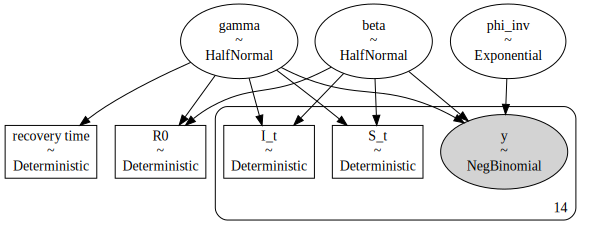

In [36]:
pm.model_to_graphviz(mod)

## Output Diagnositics

diagnostics from https://www.pymc.io/projects/examples/en/latest/case_studies/bayesian_workflow.html and Osvald, Chap 5

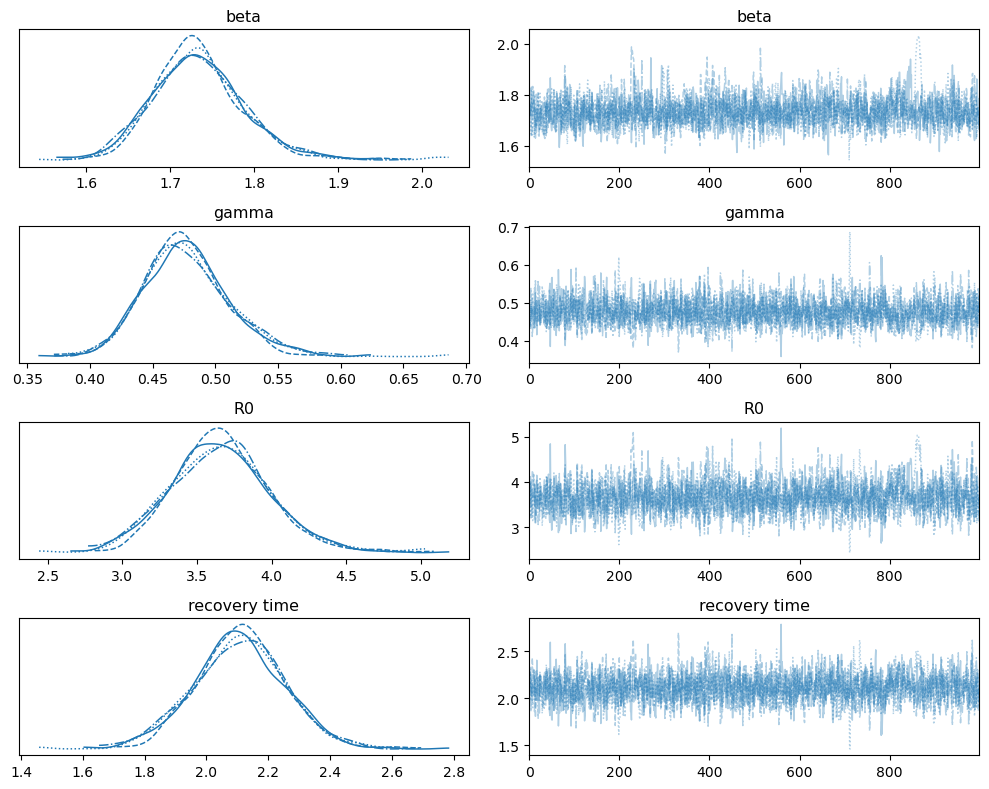

In [21]:
# Trace plots with chains in separate colors
az.plot_trace(
    idata_log,
    var_names=["beta", "gamma", "R0", "recovery time"],
    figsize=(10, 8),
    combined=False  # ensures chains are shown separately and colored
)
plt.tight_layout()
plt.show()


<Axes: >

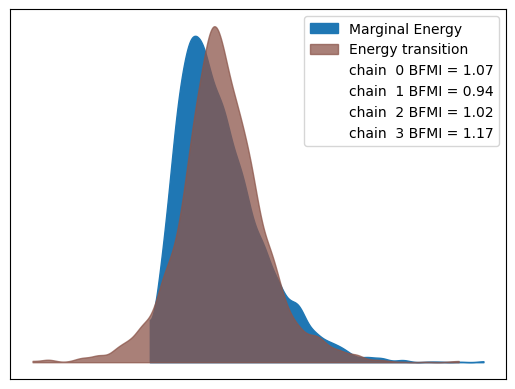

In [22]:
az.plot_energy(idata_log)

<Axes: title={'center': 'beta'}>

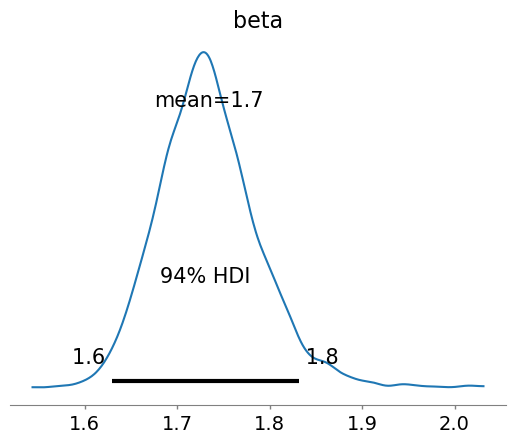

In [24]:
az.plot_posterior(idata_log, var_names=["beta"])

<Axes: title={'center': 'gamma'}>

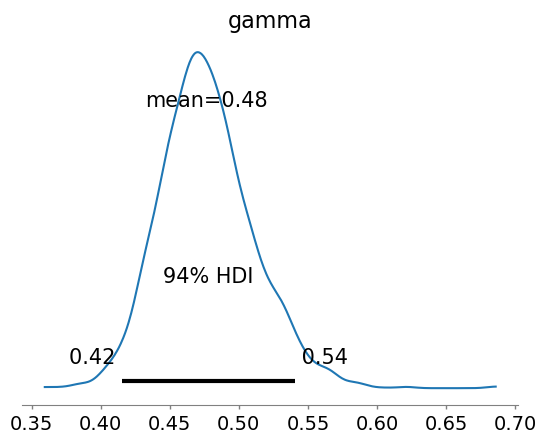

In [25]:
az.plot_posterior(idata_log, var_names=["gamma"])

<Axes: title={'center': 'R0'}>

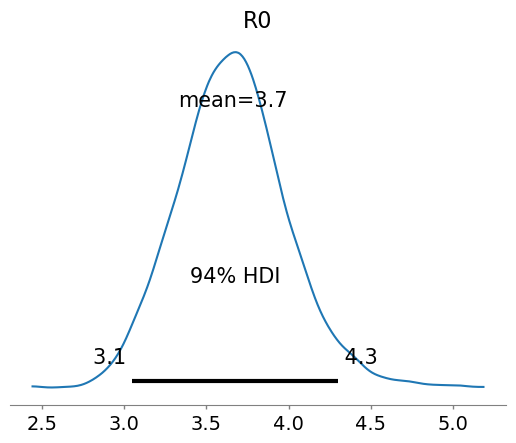

In [26]:
az.plot_posterior(idata_log, var_names=["R0"])

<Axes: title={'center': 'recovery time'}>

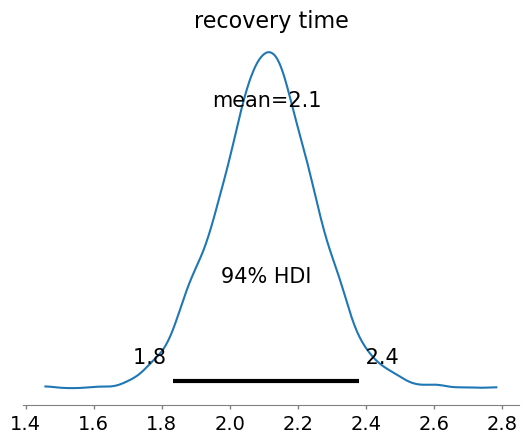

In [27]:
az.plot_posterior(idata_log, var_names=["recovery time"])

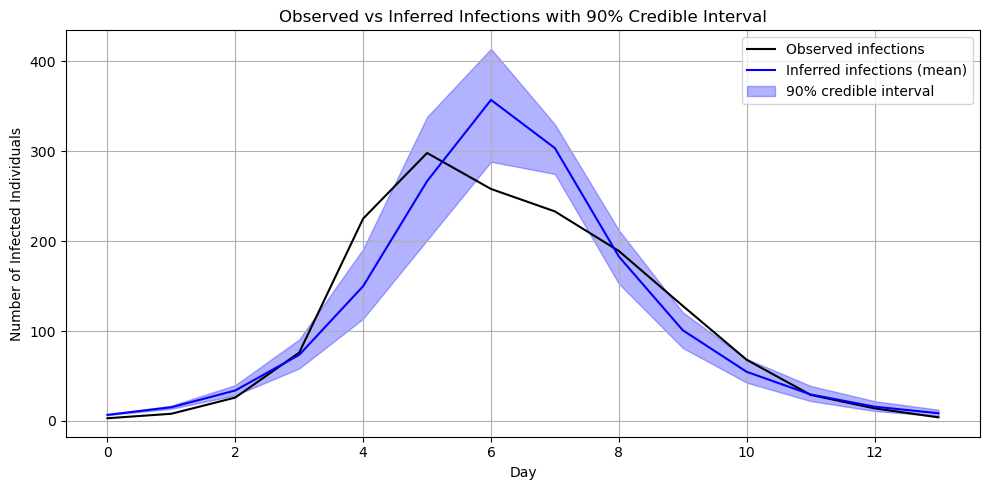

<Figure size 640x480 with 0 Axes>

In [32]:
# ----------------------------------------
# 1. Extract posterior samples of I_t
# ----------------------------------------

# Thin to reduce memory load if needed
idata_thin = idata_log.sel(draw=slice(None, None, 10))  # Optional: use if large memory use

# Stack samples across chains and draws
I_t_samples = idata_thin.posterior["I_t"].stack(sample=("chain", "draw")).values  # shape: [time, samples]

# ----------------------------------------
# 2. Compute Posterior Mean and 90% HDI
# ----------------------------------------
I_t_mean = np.mean(I_t_samples, axis=1)
I_t_lower = np.percentile(I_t_samples, 5, axis=1)
I_t_upper = np.percentile(I_t_samples, 95, axis=1)

# ----------------------------------------
# 3. Plot Observed vs Inferred Infections
# ----------------------------------------

# If you have the original observed data in a variable like `infected`:
days = np.arange(len(I_t_mean))  # or use actual time values if available

plt.figure(figsize=(10, 5))
plt.plot(days, infected, '-', label="Observed infections", color='black')
plt.plot(days, I_t_mean, label="Inferred infections (mean)", color='blue')
plt.fill_between(days, I_t_lower, I_t_upper, color='blue', alpha=0.3, label="90% credible interval")

plt.xlabel("Day")
plt.ylabel("Number of Infected Individuals")
plt.title("Observed vs Inferred Infections with 90% Credible Interval")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
plt.savefig('sir_out.png')

In [30]:
waic_log = az.waic(idata_log)
waic_log

C:\ProgramData\anaconda3\envs\pymc_env_1\Lib\site-packages\arviz\stats\stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 4000 posterior samples and 14 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   -61.89     5.09
p_waic        2.29        -

There has been a warning during the calculation. Please check the results.

In [31]:
loo_log = az.loo(idata_log)
loo_log

Computed from 4000 posterior samples and 14 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   -62.07     5.17
p_loo        2.47        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)       14  100.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%